# (draft) 2023 Wrapped: WV FOIA Edition

Let's do a play on Spotify's 2023 Wrapped, just as others have done, to review the 2023 calendar year in the sense of requests sent (and fulfilled) by government agencies under the West Virginia Freedom of Information Act (W.VA. Code §29B-1-1 et. seq.).

To start, we need to load the WVFOIA request database, do some pre-processing to prepare the data for analysis, and filter the dataset down just to requests which were submitted in 2023.

In [20]:
import sqlite3
import pandas as pd
import urllib.request

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# retrieve the most-recent database from GitHub
urllib.request.urlretrieve('https://github.com/AustinDizzy/wvfoia-sync/releases/download/v1.0.2023-12-29/wvfoia.db', '../wvfoia.db')

# connect to the database and load it into a pandas dataframe
db = sqlite3.connect('../wvfoia.db')
df = pd.read_sql('select * from entries', db)

# convert the date strings to datetime objects
df['request_date'] = pd.to_datetime(df['request_date'], format='%Y-%m-%d', errors='coerce')
df['completion_date'] = pd.to_datetime(df['completion_date'], format='%Y-%m-%d', errors='coerce')
df['entry_date'] = pd.to_datetime(df['entry_date'])

# create a filter for only requests from 2023
df_2023 = df[df['request_date'].dt.year == 2023].copy()

# print the number of requests we've loaded
print(f'{len(df_2023):,} requests')

5,816 requests


Now that we have the data loaded, we'll do something simple like getting our top individual requestors and the number of total unique requestors in the year.

In [18]:
# create a 'full_name' column
df_2023.loc[:, 'full_name'] = df_2023['first_name'] + " " + df_2023['last_name']

# count requests per individual and sort
requestors = df_2023['full_name'].value_counts()

# display the top 10 requestors
print(requestors.head(10))
 
# display the total number of unique requestors
print(f'{len(requestors):,} total requestors')

full_name
Logan Rodgers         294
Elizabeth Hott        184
Brenda Hartstein      174
Linda Robinson        134
Chelsea Latham        104
Karen Buckley          83
Claire Stancil         47
Walter Hardy           44
Flaubert Phanord       39
Jennifer McPherson     35
Name: count, dtype: int64
2,655 total requestors


In [3]:
resolution_distribution = df_2023['resolution'].value_counts()

resolution_distribution

resolution
Granted            3322
Other              1153
Rejected            639
Granted in part     533
Exempted            169
Name: count, dtype: int64

In [4]:
df_2023.loc[:, 'processing_time'] = (df['completion_date'] - df['request_date']).dt.days

# calculate average processing time
average_processing_time = df_2023['processing_time'].mean()

print(f'{average_processing_time:.1f} days')

21.2 days


In [5]:
agency_stats = (
    df_2023.groupby('agency')
    .agg(
        avg_time=('processing_time', lambda x: x.mean().round(1)),
        count=('id', 'count')
    )
    .reset_index()
)

# formatting the output and sorting
agency_stats = agency_stats[agency_stats['count'] > 1]
agency_stats.sort_values(by='avg_time', ascending=False, inplace=True)

agency_stats

,agency,avg_time,count
14,Brooke County Commission,157.0,12
167,WV Office Of Miners'' Health Safety And Training,110.4,59
3,Berkeley County Commission,102.9,644
105,Moore & Biser PLLC,82.3,3
157,WV DOH,46.5,147
...,...,...,...
1,Berkeley County Circuit Clerk,0.5,2
31,City Of Stonewood,0.0,2
4,Berkeley County Health Department,0.0,2
146,Upshur County Prosecuting Attorney,0.0,3


In [6]:
agency_stats = (
    df_2023.groupby('agency')
    .agg(
        pct_rejected=('resolution', lambda x: x.isin(('Rejected', 'Exempted')).sum() / x.count()),
        num_rejected=('resolution', lambda x: x.isin(('Rejected', 'Exempted')).sum()),
        count=('id', 'count')
    )
    .reset_index()
    .sort_values(by='pct_rejected', ascending=False)
    .query('pct_rejected > 0')
)

# display pct rejected as a percentage
agency_stats['pct_rejected'] = agency_stats['pct_rejected'].map(lambda x: f'{x:.1%}')

agency_stats

,agency,pct_rejected,num_rejected,count
69,Hardy County Circuit Clerk''s Office,100.0%,1,1
107,Morgantown Utility Board,100.0%,2,2
178,WVSOS,100.0%,2,2
159,"WV Department of Arts, Culture & History",100.0%,2,2
118,Preston County Sheriff's Office,100.0%,2,2
...,...,...,...,...
172,WV State Fire Commission,3.3%,25,750
190,West Virginia Lottery,2.1%,1,47
166,WV Investment Management Board,2.1%,2,96
74,Harrison County Commission,1.2%,1,82


In [42]:
# find agencies that received their first request in 2023
new_agencies = df.groupby('agency')['request_date'].min().reset_index()
new_agencies = new_agencies[new_agencies['request_date'].dt.year == 2023]

new_agencies

,agency,request_date
47,Berkeley County Circuit Clerk,2023-05-15
59,Board of Coal Mine Health and Safety,2023-10-19
91,Cabell County Sheriff's Office,2023-01-03
144,City of Bridgeport,2023-01-30
164,Clay County Commission,2023-09-29
251,Doddridge County Circuit Clerk''s Office,2023-10-13
311,Hardy County Circuit Clerk''s Office,2023-02-09
341,Jefferson County Clerk Office,2023-10-04
350,John Sarcopski,2023-03-09
382,Lewis County Commission for Magistrate,2023-02-23


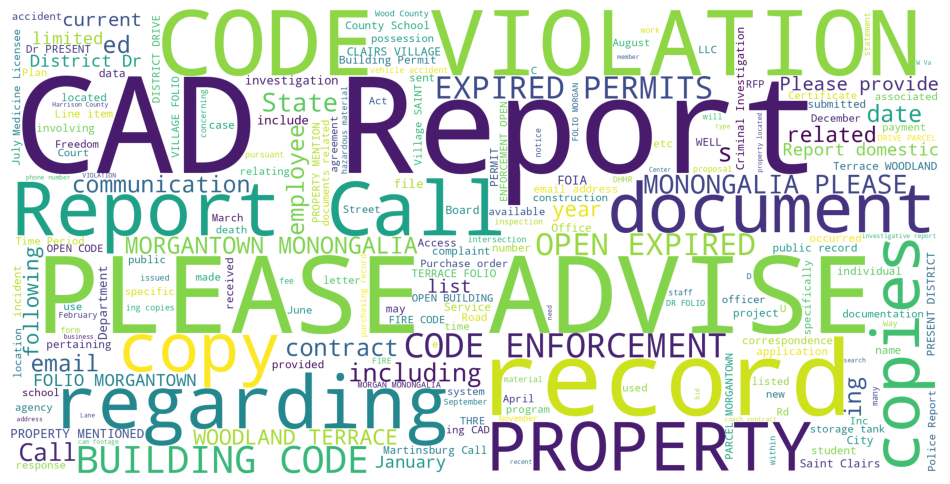

In [35]:
import re

# combine the subject and details columns into a single string
text = ' '.join(df_2023['subject'] + ' ' + df_2023['details'])

# remove some common words and phrases
text = re.sub(r'West\WVirginia|Request|information|WV|email\Wprotected', '', text, flags=re.IGNORECASE)

# create & display the wordcloud
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', width=2400, height=1200).generate(text)

plt.figure(figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()